## Задание

Постройте графики зависимости сходимости (значение функции потерь от количества итераций работы алгоритма) от выбора оптимизационного метода.

Количество эпох: 50

Сравните, сделайте выводы.

https://pytorch.org/docs/stable/optim.html

## Решение

##### Импорт

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

import os

from common.progressbar import log_progress

##### Настройки

In [2]:
# Количество эпох
EPOCHS = 50

# Коэффициент скорости обучения
LEARNING_RATE = 1e-3

# Размер пакета
BATCH_SIZE = 64

# Папка лабораторной
DIR_LAB = 'Lab4'

# Папка для загруженных данных
DIR_DATA = 'data'

# Список оптимизаторов с настройками
OPTIMIZERS = [
    { 'name': 'SGD', 'optimizer': torch.optim.SGD, 'parameters': {} },
    { 'name': 'RMSprop', 'optimizer': torch.optim.RMSprop, 'parameters': { 'alpha': 0.9 } },
    { 'name': 'Adam', 'optimizer': torch.optim.Adam, 'parameters': {} }
]

In [3]:
PATH_DATA = os.path.join(DIR_LAB, DIR_DATA)

##### Устройство

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### Класс модели

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

##### Функции тренировки модели

In [69]:
def train_loop(device, dataloader, model, loss_fn, optimizer): # batch_size=BATCH_SIZE
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    sum_loss = 0

    #for batch, (X, y) in enumerate(dataloader):
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        sum_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #if batch % 100 == 0:
            #loss, current = loss.item(), batch * batch_size + len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [70]:
def test_loop(device, dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

In [68]:
def run_training(device, train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs=EPOCHS, batch_size=BATCH_SIZE, name=None):
    #train_loss = []
    test_loss = []

    model = model.to(device)

    for t in log_progress(range(epochs), name=f'{name}: Эпоха' if name is not None else 'Эпоха'):
        #print(f"Epoch {t+1}\n-------------------------------")
        print(f"Epoch {t+1} | ", end='')
        #sum_loss = 
        train_loop(device, train_dataloader, model, loss_fn, optimizer) #, batch_size=BATCH_SIZE)
        #train_loss.append(sum_loss)

        acc, avg_loss = test_loop(device, test_dataloader, model, loss_fn)
        test_loss.append(avg_loss)

        print(f"Accuracy: {(100*acc):>0.1f}%, Avg loss: {avg_loss:>8f} ")
    #print("Done!\n")
    
    return test_loss

##### Загрузка данных

In [64]:
training_data = datasets.FashionMNIST(
    root=PATH_DATA,
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root=PATH_DATA,
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, pin_memory=True)

##### Функция потерь

In [65]:
loss_fn = nn.CrossEntropyLoss()

##### Тестируем алгоритмы

In [71]:
test_losses = []

for optimizer_entry in log_progress(OPTIMIZERS, name='Оптимизаторы'):
    #print(f'===============================\nOptimizer: {optimizer_entry['name']}\n===============================\n')

    model = NeuralNetwork()
    optimizer = optimizer_entry['optimizer'](model.parameters(), lr=LEARNING_RATE, **optimizer_entry['parameters'])

    test_losses.append(run_training(device, train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs=EPOCHS, batch_size=BATCH_SIZE, name=optimizer_entry['name']))

Epoch 1 | Accuracy: 45.8%, Avg loss: 2.178146 
Epoch 2 | Accuracy: 55.2%, Avg loss: 1.938046 
Epoch 3 | Accuracy: 59.4%, Avg loss: 1.578276 
Epoch 4 | Accuracy: 62.6%, Avg loss: 1.298048 
Epoch 5 | Accuracy: 64.4%, Avg loss: 1.121230 
Epoch 6 | Accuracy: 65.8%, Avg loss: 1.006519 
Epoch 7 | Accuracy: 67.1%, Avg loss: 0.928437 
Epoch 8 | Accuracy: 68.4%, Avg loss: 0.872679 
Epoch 9 | Accuracy: 69.6%, Avg loss: 0.830867 
Epoch 10 | Accuracy: 70.7%, Avg loss: 0.797951 
Epoch 11 | Accuracy: 72.2%, Avg loss: 0.770907 
Epoch 12 | Accuracy: 73.1%, Avg loss: 0.747797 
Epoch 13 | Accuracy: 74.0%, Avg loss: 0.727430 
Epoch 14 | Accuracy: 74.7%, Avg loss: 0.709135 
Epoch 15 | Accuracy: 75.5%, Avg loss: 0.692516 
Epoch 16 | Accuracy: 76.0%, Avg loss: 0.677277 
Epoch 17 | Accuracy: 76.8%, Avg loss: 0.663229 
Epoch 18 | Accuracy: 77.4%, Avg loss: 0.650251 
Epoch 19 | Accuracy: 77.9%, Avg loss: 0.638245 
Epoch 20 | Accuracy: 78.3%, Avg loss: 0.627118 
Epoch 21 | Accuracy: 78.8%, Avg loss: 0.616849 
E

Epoch 1 | Accuracy: 81.9%, Avg loss: 0.476772 
Epoch 2 | Accuracy: 84.7%, Avg loss: 0.426514 
Epoch 3 | Accuracy: 85.7%, Avg loss: 0.421251 
Epoch 4 | Accuracy: 84.7%, Avg loss: 0.449041 
Epoch 5 | Accuracy: 84.8%, Avg loss: 0.469721 
Epoch 6 | Accuracy: 86.4%, Avg loss: 0.447541 
Epoch 7 | Accuracy: 85.6%, Avg loss: 0.494573 
Epoch 8 | Accuracy: 87.0%, Avg loss: 0.467074 
Epoch 9 | Accuracy: 86.8%, Avg loss: 0.457237 
Epoch 10 | Accuracy: 87.5%, Avg loss: 0.516097 
Epoch 11 | Accuracy: 85.4%, Avg loss: 0.654547 
Epoch 12 | Accuracy: 87.2%, Avg loss: 0.560100 
Epoch 13 | Accuracy: 86.6%, Avg loss: 0.777135 
Epoch 14 | Accuracy: 87.8%, Avg loss: 0.598723 
Epoch 15 | Accuracy: 87.5%, Avg loss: 0.601643 
Epoch 16 | Accuracy: 87.1%, Avg loss: 0.650090 
Epoch 17 | Accuracy: 87.4%, Avg loss: 0.660146 
Epoch 18 | Accuracy: 88.3%, Avg loss: 0.628546 
Epoch 19 | Accuracy: 86.7%, Avg loss: 0.784319 
Epoch 20 | Accuracy: 87.8%, Avg loss: 0.709122 
Epoch 21 | Accuracy: 88.3%, Avg loss: 0.652920 
E

Epoch 1 | Accuracy: 84.7%, Avg loss: 0.416608 
Epoch 2 | Accuracy: 85.1%, Avg loss: 0.405365 
Epoch 3 | Accuracy: 85.8%, Avg loss: 0.380453 
Epoch 4 | Accuracy: 86.3%, Avg loss: 0.365536 
Epoch 5 | Accuracy: 86.9%, Avg loss: 0.354920 
Epoch 6 | Accuracy: 87.6%, Avg loss: 0.341062 
Epoch 7 | Accuracy: 88.0%, Avg loss: 0.342375 
Epoch 8 | Accuracy: 87.9%, Avg loss: 0.348695 
Epoch 9 | Accuracy: 87.8%, Avg loss: 0.348129 
Epoch 10 | Accuracy: 87.9%, Avg loss: 0.350994 
Epoch 11 | Accuracy: 87.3%, Avg loss: 0.381915 
Epoch 12 | Accuracy: 87.6%, Avg loss: 0.377836 
Epoch 13 | Accuracy: 87.8%, Avg loss: 0.389678 
Epoch 14 | Accuracy: 88.1%, Avg loss: 0.374302 
Epoch 15 | Accuracy: 88.0%, Avg loss: 0.420932 
Epoch 16 | Accuracy: 87.8%, Avg loss: 0.454987 
Epoch 17 | Accuracy: 88.5%, Avg loss: 0.432858 
Epoch 18 | Accuracy: 87.9%, Avg loss: 0.485156 
Epoch 19 | Accuracy: 88.7%, Avg loss: 0.471361 
Epoch 20 | Accuracy: 88.4%, Avg loss: 0.496051 
Epoch 21 | Accuracy: 88.7%, Avg loss: 0.468351 
E

##### Строим графики

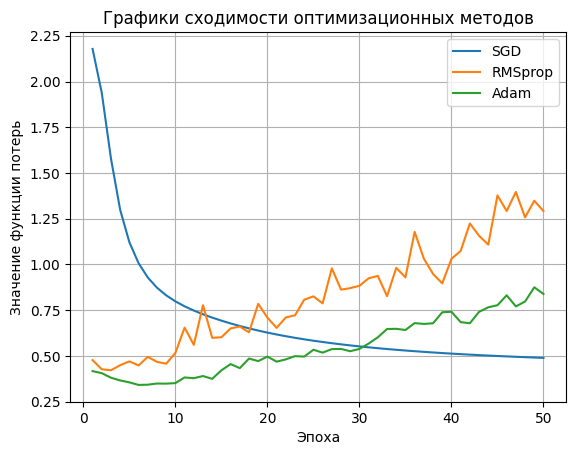

In [72]:
for optimizer_entry, test_loss in zip(OPTIMIZERS, test_losses):
    plt.plot(range(1, EPOCHS + 1), test_loss, label=optimizer_entry['name'])

plt.xlabel('Эпоха')
plt.ylabel('Значение функции потерь')
plt.title('Графики сходимости оптимизационных методов')

plt.grid(True)
plt.legend()
plt.show()

##### Выводы

- SGD: обеспечивает постепенное стабильное снижение функции потерь;
- RMSprop: быстро достигает низкой функции потерь, однако затем значение функции потерь начинает колебаться и постпенно расти;
- Adam: так же как и RMSprop - быстро достигает низкой функции потерь, затем начинает колебаться и постепенно расти, однако опять же слабее, чем RMSprop;

В итоге SGD обеспечивает медленную, но стабильную сходимость, в то время Adam и RMSprop обеспечивают быструю сходимость с последующим ростом и нестабильность функции потерь.
При этом у Adam большая сходимость, чем у RMSprop.